In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [3]:
import pathlib
import pandas as pd
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [4]:
DATA_FILE = "/content/drive/MyDrive/datasets/sc2021_train_deals.csv"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]
RS = 79736

# Загрузка данных

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv(DATA_FILE, parse_dates=["month", "date"])

In [7]:
data

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...
92301,134,0,Украина,Украина,18156,2020-07-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2020-07-31,21.0
92302,486,0,Россия,Ростовская обл.,16156,2020-07-01,Базовые полимеры,ПП,ПП,Спот,2020-07-31,3.0
92303,276,7372,Польша,Польша,17029,2020-07-01,Базовые полимеры,ПП,ПП,Контракт,2020-07-31,25.0
92304,583,5983,Россия,Респ. Башкортостан,16788,2020-07-01,Пластики и продукты органического синтеза,ПСВ,Полистирол,Контракт,2020-07-31,21.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92306 entries, 0 to 92305
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   material_code       92306 non-null  int64         
 1   company_code        92306 non-null  int64         
 2   country             92306 non-null  object        
 3   region              92306 non-null  object        
 4   manager_code        92306 non-null  int64         
 5   month               92306 non-null  datetime64[ns]
 6   material_lvl1_name  92306 non-null  object        
 7   material_lvl2_name  92306 non-null  object        
 8   material_lvl3_name  92306 non-null  object        
 9   contract_type       92306 non-null  object        
 10  date                92306 non-null  datetime64[ns]
 11  volume              92306 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.5+ MB


Временной диапазон тренировочного множества:

In [9]:
data.month.min(), data.month.max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))

# Временные ряды

In [10]:
from scipy.special import boxcox1p, inv_boxcox1p
from sklearn.preprocessing import StandardScaler

In [11]:
# группируем по пяти колонкам и месяцу, чтобы получить 914 групп, 
# на данных которых будем обучаться
group_ts = data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)

In [12]:
group_ts_orig = data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)

In [13]:
# логарифмируем (выручку + 1)
for i in range(0,941):
    group_ts.iloc[i] = np.log10(group_ts.iloc[i]+1)
    # group_ts.iloc[i][group_ts.iloc[i] == 0] = 0.001

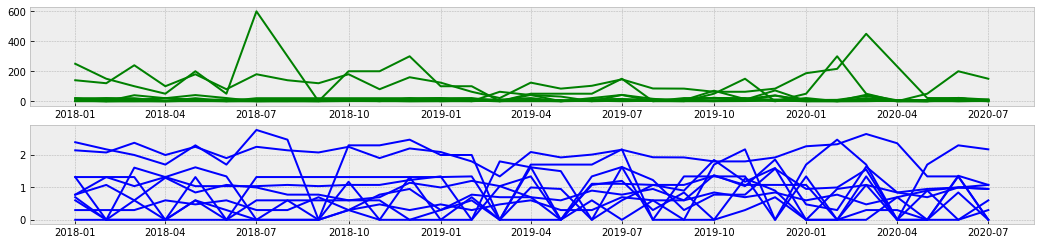

In [14]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18,4))
for ROW_ID in range(20,30):
    ax1.plot(group_ts_orig.iloc[ROW_ID],c='green')
    ax2.plot(group_ts.iloc[ROW_ID],c='blue')

# Baseline #3: CatBoostRegressor

Признаки:

- оригинальные категориальные признаки,
- месяц, для которого предсказываем,
- среднее, минимум и максимум за год,
- последние 6 месяцев до месяца, для которого предсказываем.

Для тренировки будем использовать период `2019-01-01` по `2019-06-01`, для валидации: с `2019-07-01` по `2019-12-01`, для тестирования: с `2020-01-01` по `2020-07-01`.

In [15]:
def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Calculate features for `month`."""

    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features["month"] = month.month
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    features["vol_tm2_diff"] = features["vol_tm1"] - features["vol_tm2"]
    features["vol_tm3_diff"] = features["vol_tm2"] - features["vol_tm3"]
    features["vol_tm4_diff"] = features["vol_tm3"] - features["vol_tm4"]
    features["vol_tm5_diff"] = features["vol_tm4"] - features["vol_tm5"]
    features["vol_tm6_diff"] = features["vol_tm5"] - features["vol_tm6"]  

    features["vol_tm2_diff_last"] = features["vol_tm1"] - features["vol_tm2"]
    features["vol_tm3_diff_last"] = features["vol_tm1"] - features["vol_tm3"]
    features["vol_tm4_diff_last"] = features["vol_tm1"] - features["vol_tm4"]
    features["vol_tm5_diff_last"] = features["vol_tm1"] - features["vol_tm5"]
    features["vol_tm6_diff_last"] = features["vol_tm1"] - features["vol_tm6"]
         

    if month.month in [3,4,5]:
        features["season"] = 1
    elif month.month in [6,7,8]:
        features["season"] = 2
    elif month.month in [9,10,11]:
        features["season"] = 3
    else:
        features["season"] = 4              
  
    
    rolling = df.rolling(6, axis=1, min_periods=1)
    features = features.join(rolling.median().iloc[:, -1].rename("last_six_med"))
    features = features.join(rolling.mean().iloc[:, -1].rename("last_six_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_six_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_six_max"))    

    rolling = df.rolling(3, axis=1, min_periods=1)
    features = features.join(rolling.median().iloc[:, -1].rename("last_3_med"))
    features = features.join(rolling.mean().iloc[:, -1].rename("last_3_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_3_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_3_max"))        

    rolling = df.rolling(12, axis=1, min_periods=1)
    features = features.join(rolling.median().iloc[:, -1].rename("last_12_med"))
    features = features.join(rolling.mean().iloc[:, -1].rename("last_12_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_12_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_12_max"))  

    features['e1'] = features[f'vol_tm2']+(features[f'vol_tm1']-features[f'vol_tm2'])*2
    features['e2'] = features[f'vol_tm1']+(features[f'vol_tm1']-features[f'vol_tm2'])
    

    features['count0_last_year'] = df[df==0].iloc[:,-12:].isna().sum(axis=1)


    features["month"] = month.month


    return features

In [16]:
tr_range = pd.date_range("2019-01-01", "2019-06-01", freq="MS")
val_range = pd.date_range("2019-07-01", "2019-12-01", freq="MS")
ts_range = pd.date_range("2020-01-01", "2020-07-01", freq="MS")

In [17]:
full_features = {}

for dataset, dataset_range in zip(["tr", "val", "ts"], [tr_range, val_range, ts_range]):
    dataset_features = []
    for target_month in dataset_range:
        features = get_features(group_ts, target_month)
        features["target"] = group_ts[target_month]
        dataset_features.append(features.reset_index())
    full_features[dataset] = pd.concat(dataset_features, ignore_index=True)

In [ ]:
full_features["tr"]

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,vol_tm2_diff,vol_tm3_diff,vol_tm4_diff,vol_tm5_diff,vol_tm6_diff,season,last_y_med,last_six_avg,last_six_min,last_six_max,last_3_avg,last_3_min,last_3_max,target
0,124,7278,Россия,Респ. Татарстан,17460,1,5.398163,5.398163,5.398163,5.638355,5.638355,5.638355,0.000000,0.000000,0.240192,0.000000,0.000000,4,5.524659,5.518259,5.398163,5.638355,5.638355,5.638355,5.638355,5.303305
1,133,0,Белоруссия,Минская обл.,10942,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,133,0,Белоруссия,Могилевская обл.,10942,1,0.000000,0.000000,4.615121,5.398163,3.044522,0.000000,-3.044522,-2.353640,0.783042,4.615121,0.000000,4,0.000000,2.176301,0.000000,5.398163,2.814228,0.000000,5.398163,0.000000
3,133,0,Белоруссия,г. Минск,10942,1,5.198497,4.605170,4.110874,5.993961,4.795791,3.044522,-1.751268,-1.198171,1.883088,-0.494296,-0.593327,4,3.912223,4.624803,3.044522,5.993961,4.611425,3.044522,5.993961,3.713572
4,133,0,Казахстан,г. Нур-Султан,13301,1,3.713572,3.044522,3.713572,3.433987,0.000000,3.713572,3.713572,-3.433987,-0.279585,0.669050,-0.669050,4,3.239255,2.936538,0.000000,3.713572,2.382520,0.000000,3.713572,3.713572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,986,9943,Россия,Смоленская обл.,17460,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5642,998,0,Россия,Ленинградская обл.,18079,6,0.000000,1.791759,1.791759,0.000000,2.197225,1.791759,-0.405465,2.197225,-1.791759,0.000000,1.791759,2,1.700599,1.262084,0.000000,2.197225,1.329661,0.000000,2.197225,2.397895
5643,998,3380,Россия,Ленинградская обл.,14956,6,0.000000,0.000000,0.000000,4.394449,4.553877,4.852030,0.298153,0.159428,4.394449,0.000000,0.000000,2,0.000000,2.300059,0.000000,4.852030,4.600119,4.394449,4.852030,4.804021
5644,998,5410,Россия,г. Санкт-Петербург,14956,6,4.615121,4.795791,4.787492,5.081404,4.795791,4.948760,0.152969,-0.285614,0.293913,-0.008299,0.180670,2,4.615121,4.837393,4.615121,5.081404,4.941985,4.795791,5.081404,4.615121


# CATBOOST

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate

In [ ]:
CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month"]
FTS_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month",
            "vol_tm6", "vol_tm5", "vol_tm4", "vol_tm3", "vol_tm2", "vol_tm1", "season",
            "last_six_avg", "last_six_min", "last_six_max","last_six_med",
            "last_3_avg", "last_3_min", "last_3_max", "last_3_med",
            "last_12_avg", "last_12_min", "last_12_max", "last_12_med",
            "vol_tm6_diff","vol_tm5_diff", "vol_tm4_diff", "vol_tm3_diff", "vol_tm2_diff",
            "vol_tm6_diff_last","vol_tm5_diff_last", "vol_tm4_diff_last", "vol_tm3_diff_last", "vol_tm2_diff_last",
            "e1","e2"]
TARGET = "target"

In [ ]:
RS = 79635

In [ ]:
model = CatBoostRegressor(iterations=1000,
                          # learning_rate = 0.1,
                          early_stopping_rounds=30,
                          depth=6,
                          cat_features=CAT_COLS,
                          random_state=RS,
                          verbose = 10)

In [ ]:
model.fit(full_features["tr"][FTS_COLS], full_features["tr"][TARGET],
          eval_set=(full_features["val"][FTS_COLS], full_features["val"][TARGET]))

Learning rate set to 0.066822
0:	learn: 0.9377680	test: 0.9263740	best: 0.9263740 (0)	total: 72ms	remaining: 1m 11s
10:	learn: 0.7445626	test: 0.7502509	best: 0.7502509 (10)	total: 295ms	remaining: 26.5s
20:	learn: 0.6754669	test: 0.6929416	best: 0.6929416 (20)	total: 534ms	remaining: 24.9s
30:	learn: 0.6486693	test: 0.6758690	best: 0.6758690 (30)	total: 764ms	remaining: 23.9s
40:	learn: 0.6356753	test: 0.6713597	best: 0.6713597 (40)	total: 982ms	remaining: 23s
50:	learn: 0.6294115	test: 0.6702746	best: 0.6702746 (50)	total: 1.18s	remaining: 22s
60:	learn: 0.6241562	test: 0.6698434	best: 0.6697591 (59)	total: 1.4s	remaining: 21.5s
70:	learn: 0.6202028	test: 0.6700885	best: 0.6697591 (59)	total: 1.58s	remaining: 20.7s
80:	learn: 0.6150152	test: 0.6707566	best: 0.6697591 (59)	total: 1.8s	remaining: 20.4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.669759072
bestIteration = 59

Shrink model to first 60 iterations.


In [ ]:
pd.Series(model.feature_importances_, index=FTS_COLS).sort_values(ascending=False)

vol_tm1              16.564626
vol_tm2              11.468724
last_3_avg            9.126495
last_3_max            7.007987
e1                    5.521958
e2                    5.230218
last_12_med           4.712695
last_3_med            4.638226
last_12_avg           4.092132
last_six_avg          3.603964
last_six_max          3.226197
season                2.715687
last_six_med          2.048800
vol_tm5_diff_last     1.819617
vol_tm3               1.692921
vol_tm4               1.557926
material_code         1.418118
month                 1.292149
vol_tm6               1.051774
manager_code          1.004445
vol_tm5               0.962732
last_12_max           0.956324
vol_tm3_diff_last     0.953556
last_12_min           0.943769
vol_tm4_diff_last     0.883220
vol_tm6_diff_last     0.841633
country               0.839169
vol_tm2_diff          0.713300
last_3_min            0.596221
vol_tm3_diff          0.525264
vol_tm5_diff          0.524460
vol_tm4_diff          0.419186
vol_tm2_

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(full_features["tr"][FTS_COLS])

In [ ]:
shap.summary_plot(shap_values, full_features["tr"][FTS_COLS])

In [ ]:
tr_preds =  10**(model.predict(full_features["tr"][FTS_COLS]))-1
val_preds = 10**(model.predict(full_features["val"][FTS_COLS]))-1
ts_preds =  10**(model.predict(full_features["ts"][FTS_COLS]))-1

In [ ]:
tr_preds[tr_preds < 0] = 0
val_preds[val_preds < 0] = 0
ts_preds[ts_preds < 0] = 0

In [ ]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(tr_target, tr_preds)):.4f}')

Ошибка на тренировочном множестве: 2.0002


In [ ]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(10**(full_features["tr"][TARGET])-1, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(10**(full_features["val"][TARGET])-1, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(10**(full_features["ts"][TARGET])-1, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.4401
Ошибка на валидационном множестве: 1.5422
Ошибка на тестовом множестве: 1.7329


In [ ]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["tr"][TARGET]), tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["val"][TARGET]), val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["ts"][TARGET]), ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.4532
Ошибка на валидационном множестве: 1.5413
Ошибка на тестовом множестве: 1.7357


In [ ]:
tr_preds

array([199.65940492,   0.78275935,   4.79231874, ...,  49.00672545,
       107.08542836,   6.70915285])

# STACKING

In [18]:
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import BayesianRidge, LinearRegression

In [19]:
pip install --upgrade xgboost

     |████████████████████████████████| 173.5 MB 13 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [20]:
from xgboost import XGBRegressor

In [21]:
CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month"]
FTS_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month",
            "vol_tm6", "vol_tm5", "vol_tm4", "vol_tm3", "vol_tm2", "vol_tm1", "season",
            "last_six_avg", "last_six_min", "last_six_max","last_six_med",
            "last_3_avg", "last_3_min", "last_3_max", "last_3_med",
            "last_12_avg", "last_12_min", "last_12_max", "last_12_med",
            "vol_tm6_diff","vol_tm5_diff", "vol_tm4_diff", "vol_tm3_diff", "vol_tm2_diff",
            "vol_tm6_diff_last","vol_tm5_diff_last", "vol_tm4_diff_last", "vol_tm3_diff_last", "vol_tm2_diff_last",
            "e1","e2"]
TARGET = "target"

In [22]:
xgb =  XGBRegressor(random_state = RS,n_estimators = 90, eta = 0.05, reg_alpha = 40, reg_lambda = 0.1,
                                colsample_bytree = 0.6, subsample  = 1)
lgb = LGBMRegressor(
                                random_state = RS, learning_rate = 0.05,
                                 max_depth = 3, metric = 'rmse', num_leaves =  7, 
                                 n_estimators = 90)

cat = CatBoostRegressor(logging_level = 'Silent', random_state = RS, depth = 9, learning_rate = 0.02, iterations = 180)

In [23]:
lin = LinearRegression()
bay = BayesianRidge()

In [24]:
estimators = [
('XGB',xgb),
('Bayes', cat),
('Light', lgb),
]
stack_gen = StackingRegressor(estimators=estimators, final_estimator = bay)

In [25]:
le = LabelEncoder()
full_features["tr"]['region'] = le.fit_transform(full_features["tr"]['region'])
full_features["tr"]['country'] = le.fit_transform(full_features["tr"]['country'])
full_features["val"]['region'] = le.fit_transform(full_features["val"]['region'])
full_features["val"]['country'] = le.fit_transform(full_features["val"]['country'])
full_features["ts"]['region'] = le.fit_transform(full_features["ts"]['region'])
full_features["ts"]['country'] = le.fit_transform(full_features["ts"]['country'])

In [26]:
stack_gen.fit(full_features["tr"][FTS_COLS], full_features["tr"][TARGET])

StackingRegressor(estimators=[('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6,
                                            enable_categorical=False, eta=0.05,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_c...
                                            predictor=None, random_state=79736,
                                  

In [27]:
tr_preds =  (10**(stack_gen.predict(full_features["tr"][FTS_COLS]))-1)
val_preds = (10**(stack_gen.predict(full_features["val"][FTS_COLS]))-1)
ts_preds =  (10**(stack_gen.predict(full_features["ts"][FTS_COLS]))-1)
tr_preds[tr_preds < 0] = 0
val_preds[val_preds < 0] = 0
ts_preds[ts_preds < 0] = 0

In [28]:
tr_preds

array([183.56149943,   0.57774847,   3.03492295, ...,  57.07145553,
       121.15160393,   5.23986242])

In [29]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(10**(full_features["tr"][TARGET])-1, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(10**(full_features["val"][TARGET])-1, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(10**(full_features["ts"][TARGET])-1, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.3581
Ошибка на валидационном множестве: 1.5458
Ошибка на тестовом множестве: 1.7321


In [ ]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["tr"][TARGET]), tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["val"][TARGET]), val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["ts"][TARGET]), ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.3667
Ошибка на валидационном множестве: 1.5422
Ошибка на тестовом множестве: 1.7318


In [ ]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["tr"][TARGET]), tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["val"][TARGET]), val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(np.expm1(full_features["ts"][TARGET]), ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.3666
Ошибка на валидационном множестве: 1.5486
Ошибка на тестовом множестве: 1.7339


In [30]:
import joblib

In [31]:
joblib.dump(stack_gen,'pipe_with_stack.pkl')

['pipe_with_stack.pkl']

# Выгрузка stack

In [38]:
%%writefile predict.py

import pathlib
import pandas as pd
import math
import numpy as np
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import joblib

MODEL_FILE = pathlib.Path(__file__).parent.joinpath("pipe_with_stack.pkl")
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

def get_features_(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисление признаков для `month`."""

    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features["month"] = month.month
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    features["vol_tm2_diff"] = features["vol_tm1"] - features["vol_tm2"]
    features["vol_tm3_diff"] = features["vol_tm2"] - features["vol_tm3"]
    features["vol_tm4_diff"] = features["vol_tm3"] - features["vol_tm4"]
    features["vol_tm5_diff"] = features["vol_tm4"] - features["vol_tm5"]
    features["vol_tm6_diff"] = features["vol_tm5"] - features["vol_tm6"]  

    features["vol_tm2_diff_last"] = features["vol_tm1"] - features["vol_tm2"]
    features["vol_tm3_diff_last"] = features["vol_tm1"] - features["vol_tm3"]
    features["vol_tm4_diff_last"] = features["vol_tm1"] - features["vol_tm4"]
    features["vol_tm5_diff_last"] = features["vol_tm1"] - features["vol_tm5"]
    features["vol_tm6_diff_last"] = features["vol_tm1"] - features["vol_tm6"]
         

    if month.month in [3,4,5]:
        features["season"] = 1
    elif month.month in [6,7,8]:
        features["season"] = 2
    elif month.month in [9,10,11]:
        features["season"] = 3
    else:
        features["season"] = 4              
  
    
    rolling = df.rolling(6, axis=1, min_periods=1)
    features = features.join(rolling.median().iloc[:, -1].rename("last_six_med"))
    features = features.join(rolling.mean().iloc[:, -1].rename("last_six_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_six_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_six_max"))    

    rolling = df.rolling(3, axis=1, min_periods=1)
    features = features.join(rolling.median().iloc[:, -1].rename("last_3_med"))
    features = features.join(rolling.mean().iloc[:, -1].rename("last_3_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_3_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_3_max"))        

    rolling = df.rolling(12, axis=1, min_periods=1)
    features = features.join(rolling.median().iloc[:, -1].rename("last_12_med"))
    features = features.join(rolling.mean().iloc[:, -1].rename("last_12_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_12_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_12_max"))  


    features["month"] = month.month
    
    return features.reset_index()


def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:

    group_ts = df.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)
    # логарифмируем (выручку + 1)
    for i in range(0,941):
        group_ts.iloc[i] = np.log10(group_ts.iloc[i]+1)  
    features = get_features_(group_ts, month)

    le1 = LabelEncoder()
    features['region'] = le1.fit_transform(features['region'])
    le2 = LabelEncoder()
    features['country'] = le2.fit_transform(features['country'])

    FTS_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month",
                "vol_tm6", "vol_tm5", "vol_tm4", "vol_tm3", "vol_tm2", "vol_tm1", "season",
                "last_six_avg", "last_six_min", "last_six_max","last_six_med",
                "last_3_avg", "last_3_min", "last_3_max", "last_3_med",
                "last_12_avg", "last_12_min", "last_12_max", "last_12_med",
                "vol_tm6_diff","vol_tm5_diff", "vol_tm4_diff", "vol_tm3_diff", "vol_tm2_diff",
                "vol_tm6_diff_last","vol_tm5_diff_last", "vol_tm4_diff_last", "vol_tm3_diff_last", "vol_tm2_diff_last"]

    model = joblib.load(MODEL_FILE)
    predictions = model.predict(features[FTS_COLS])
    preds_df = features[AGG_COLS].copy()
    preds_df['region'] = le1.inverse_transform(preds_df['region'])
    preds_df['country'] = le2.inverse_transform(preds_df['country'])    
    preds_df["prediction"] = 10**(predictions) - 1
    return preds_df
    

Overwriting predict.py


In [33]:
import predict

In [34]:
predict.get_features_(group_ts.iloc[:, :-1], pd.Timestamp("2020-07-01"))

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,vol_tm2_diff,vol_tm3_diff,vol_tm4_diff,vol_tm5_diff,vol_tm6_diff,vol_tm2_diff_last,vol_tm3_diff_last,vol_tm4_diff_last,vol_tm5_diff_last,vol_tm6_diff_last,season,last_six_med,last_six_avg,last_six_min,last_six_max,last_3_med,last_3_avg,last_3_min,last_3_max,last_12_med,last_12_avg,last_12_min,last_12_max,e1,e2,count0_last_year
0,124,7278,Россия,Респ. Татарстан,17460,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.590520e-16,0.000000,0.000000,0.000000,0.000000,0
1,133,0,Белоруссия,Минская обл.,10942,7,1.255273,1.863323,2.399674,2.596597,2.460898,2.324282,-0.136615,-0.135699,0.196923,0.536351,0.608050,-0.136615,-0.272315,-0.075391,0.460960,1.069010,2,2.361978,2.150008,1.255273,2.596597,2.460898,2.460592,2.324282,2.596597,2.289067,2.154911e+00,1.255273,2.596597,2.187667,2.187667,12
2,133,0,Белоруссия,Могилевская обл.,10942,7,0.000000,0.000000,0.000000,2.222716,1.799341,0.000000,-1.799341,-0.423376,2.222716,0.000000,0.000000,-1.799341,-2.222716,0.000000,0.000000,0.000000,2,0.000000,0.670343,0.000000,2.222716,1.799341,1.340686,0.000000,2.222716,0.000000,3.351714e-01,0.000000,2.222716,-1.799341,-1.799341,2
3,133,0,Белоруссия,г. Минск,10942,7,0.000000,0.000000,0.000000,1.342423,0.000000,0.000000,0.000000,-1.342423,1.342423,0.000000,0.000000,0.000000,-1.342423,0.000000,0.000000,0.000000,2,0.000000,0.223737,0.000000,1.342423,0.000000,0.447474,0.000000,1.342423,0.000000,7.035415e-01,0.000000,1.924279,0.000000,0.000000,5
4,133,0,Казахстан,г. Нур-Султан,13301,7,0.000000,1.707570,1.612784,0.000000,0.000000,1.707570,1.707570,0.000000,-1.612784,-0.094786,1.707570,1.707570,1.707570,0.094786,0.000000,1.707570,2,0.806392,0.837987,0.000000,1.707570,0.000000,0.569190,0.000000,1.707570,1.612784,1.107215e+00,0.000000,1.707570,3.415140,3.415140,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,7,0.000000,1.342423,1.806180,2.100371,1.929419,1.929419,0.000000,-0.170952,0.294191,0.463757,1.342423,0.000000,-0.170952,0.123239,0.586996,1.929419,2,1.867799,1.517969,0.000000,2.100371,1.929419,1.986403,1.929419,2.100371,0.000000,7.589843e-01,0.000000,2.100371,1.929419,1.929419,5
937,998,0,Россия,Ленинградская обл.,18079,7,0.778151,0.778151,0.778151,0.000000,0.602060,0.602060,0.000000,0.602060,-0.778151,0.000000,0.000000,0.000000,0.602060,-0.176091,-0.176091,-0.176091,2,0.690106,0.589762,0.000000,0.778151,0.602060,0.401373,0.000000,0.602060,0.778151,6.685633e-01,0.000000,1.041393,0.602060,0.602060,10
938,998,3380,Россия,Ленинградская обл.,14956,7,1.869232,1.875061,2.089905,2.004321,1.204120,1.491362,0.287242,-0.800201,-0.085584,0.214844,0.005830,0.287242,-0.512960,-0.598543,-0.383700,-0.377870,2,1.872146,1.755667,1.204120,2.089905,1.491362,1.566601,1.204120,2.004321,2.008579,1.863384e+00,1.204120,2.113943,1.778603,1.778603,12
939,998,5410,Россия,г. Санкт-Петербург,14956,7,2.004321,2.257679,2.257679,2.004321,2.149219,1.612784,-0.536435,0.144898,-0.253357,0.000000,0.253357,-0.536435,-0.391538,-0.644895,-0.644895,-0.391538,2,2.076770,2.047667,1.612784,2.257679,2.004321,1.922108,1.612784,2.149219,2.082785,2.049699e+00,1.612784,2.257679,1.076349,1.076349,12


In [35]:
pred = predict.predict(data[data.month<"2020-07-01"], pd.Timestamp("2020-07-01"))

In [36]:
pred

,material_code,company_code,country,region,manager_code,prediction
0,124,7278,Россия,Респ. Татарстан,17460,0.577028
1,133,0,Белоруссия,Минская обл.,10942,155.510155
2,133,0,Белоруссия,Могилевская обл.,10942,4.892725
3,133,0,Белоруссия,г. Минск,10942,2.393048
4,133,0,Казахстан,г. Нур-Султан,13301,11.928198
...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,45.410039
937,998,0,Россия,Ленинградская обл.,18079,2.377297
938,998,3380,Россия,Ленинградская обл.,14956,32.842219
939,998,5410,Россия,г. Санкт-Петербург,14956,57.914278


# Tuning CATBOOST

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedKFold, KFold

In [ ]:
cv = RepeatedKFold(n_repeats = 3,n_splits = 5, random_state = 42)
params = { "learning_rate": np.linspace(0,0.2,10),
               "depth": np.arange(4, 11)}

In [ ]:
%%time

clf = RandomizedSearchCV(CatBoostRegressor(
                          early_stopping_rounds=30,
                          cat_features=CAT_COLS,
                          random_state=RS,
                          verbose=10),
                           params,
                            cv = cv)


clf.fit(full_features["tr"][FTS_COLS], full_features["tr"][TARGET],
          eval_set=(full_features["val"][FTS_COLS], full_features["val"][TARGET]))

In [ ]:
print(clf.best_params_)
print(clf.best_score_)

# Подбор числа деревьев:

In [ ]:
%%time
cv = KFold(n_splits = 5, random_state = 42, shuffle = True)
from sklearn.model_selection import validation_curve
train_scores_iter, valid_scores_iter = validation_curve(
        CatBoostRegressor(task_type = 'GPU',
                          cat_features=CAT_COLS,
                          random_state=RS,
                          verbose=10),
                          full_features["tr"][FTS_COLS], full_features["tr"][TARGET], # обучусь тут, потом проверю на validation
                            param_name="iterations",
                             param_range=np.arange(1, 1002, 10),cv=cv)

Качество на valid:

In [ ]:
%%time
model = CatBoostRegressor(task_type = 'GPU',
                          iterations = 500,
                          cat_features=CAT_COLS,
                          random_state=RS,
                          verbose=100)
model.fit(full_features["tr"][FTS_COLS], full_features["tr"][TARGET],
          eval_set=(full_features["val"][FTS_COLS], full_features["val"][TARGET]))
preds = model.predict(full_features["val"][FTS_COLS])
print("Ошибка на valid множестве:",
      f'{np.sqrt(mean_squared_error(np.expm1(full_features["val"][TARGET]), preds)):.4f}')

Лучшее = 500, далее lr:

In [ ]:
%%time
cv = KFold(n_splits = 5, random_state = 42, shuffle = True)
from sklearn.model_selection import validation_curve
train_scores, valid_scores = validation_curve(
        CatBoostRegressor(task_type = 'GPU',
                          iterations = 500,
                          cat_features=CAT_COLS,
                          random_state=RS,
                          verbose=100,
                         loss_function='RMSE'),
                          full_features["tr"][FTS_COLS], full_features["tr"][TARGET], # обучусь тут, потом проверю на validation
                            param_name="learning_rate",
                             param_range=np.linspace(0.001, 0.1, 50),cv=cv)

In [ ]:
lr_range=np.linspace(0.001, 0.1, 50)
plt.plot(lr_range,np.mean(train_scores, axis = 1))
plt.plot(lr_range,np.mean(valid_scores, axis = 1))
plt.legend(['Train error', 'Valid error'])

In [ ]:
iter_range=np.arange(100, 1001, 100)
plt.plot(iter_range,np.mean(train_scores_iter, axis = 1))
plt.plot(iter_range,np.mean(valid_scores_iter, axis = 1))

In [ ]:
np.mean(train_scores, axis = 1)